In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
%run imports.py

In [3]:
ds = mnist.MNIST()
net = mnist.Network()

In [4]:
ds.calc_performance(net, tqdm=tqdm)

  0%|          | 0/4 [00:00<?, ?it/s]

{'loss': 2.309080147743225,
 'acc': 0.1044,
 'meter_loss': <metrics.AverageMeter at 0x7fe2122f03a0>,
 'meter_acc': <metrics.AverageMeter at 0x7fe21245c2b0>}

In [35]:
net = mnist.Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)

meter_acc = metrics.AverageMeter(keep_verbose_stats=True)
meter_loss = metrics.AverageMeter(keep_verbose_stats=True)

for epoch_idx in range(5):
    for x, y in tqdm(ds.dl_train):
        yp = net(x)
        loss = ds.loss_fn(yp, y)
        acc = (yp.argmax(dim=-1)==y).sum().item()/len(x)

        opt.zero_grad()
        loss.backward()
        opt.step()

        meter_acc.update(acc, len(x))
        meter_loss.update(loss.item(), len(x))

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

(0.0, 900.0)

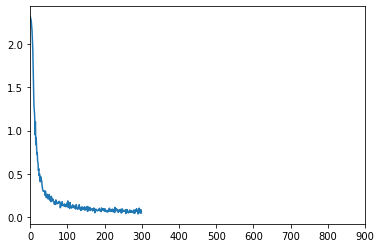

In [37]:
plt.plot(np.array(meter_loss.data)[:, 0])
plt.xlim(0, 900)

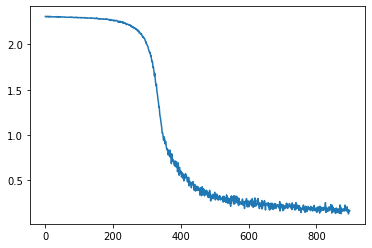

In [34]:
plt.plot(np.array(meter_loss.data)[:, 0])

In [1]:
# import mnist

import torch
from torch import nn
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
from mnist import MNIST

In [5]:
def intercept(v1, g1, v2, g2):
    '''
    from: https://math.stackexchange.com/questions/1036959/midpoint-of-the-shortest-distance-between-2-rays-in-3d
    '''
    def dot(a, b):
        return (a*b).sum(dim=-1)
    
    a, b, c, d = v1, g1, v2, g2
    
    bd = dot(b, d)
    ad = dot(a, d)
    bc = dot(b, c)
    cd = dot(c, d) 
    ab = dot(a, b)
    
    s = (bd*(ad-bc)-ad*cd)/(bd**2.-1.)
    t = (bd*(cd-ad)-bc*ab)/(bd**2.-1.)
    
    return (a+c+b*t[:, None]+d*s[:, None])/2.

def intercept(v1, g1, v2, g2):
    '''
    from: https://math.stackexchange.com/questions/3242011/finding-the-closest-two-points-on-two-lines-in-n-dimensions
    '''
    
    bs = v1.shape[:-1]
    def dot(a, b):
        return (a*b).sum(dim=-1)
    
    g1 = g1/g1.norm(dim=-1, keepdim=True)
    g2 = g2/g2.norm(dim=-1, keepdim=True)
    
    a, b, c, d = v1, g1, v2, g2
    
    # Ax = B
    A = torch.zeros(*bs, 2, 2)
    B = torch.zeros(*bs, 2)
    A[..., 0, 0] = b.norm(dim=-1)**2.
    A[..., 0, 1] = -dot(b, d)
    A[..., 1, 0] = -dot(b, d)
    A[..., 1, 1] = d.norm(dim=-1)**2.
    
    
    B[..., 0] = -dot(a-c, b)
    B[..., 1] = dot(a-c, d)
    
#     print(A)
#     print(torch.matrix_rank(A))
#     print(A.det())
#     print(A.inverse())
    
    st = (A.inverse()@B[..., None])[..., 0]
    s, t = st[..., 0], st[..., 1]
    
    # TODO clip s, t to 0 as lower limit
    
#     if s<0 or t<0:
#         print('st ', s,t)
    
    return (a+c+b*s[..., None]+d*t[..., None])/2., s, t

In [6]:
from functions import *

In [7]:
def fn_quad(x):
    return x.norm(dim=-1)**2

def fg_fn(x, fn):
    x = x.detach().requires_grad_()
    loss = fn(x)
    loss.backward()
    return loss, x.grad

fn = rosenbrock

In [8]:
def calc_sgd_trajectory(x, steps, lr=1e-1):
    traj = [] # trajectory
    traj_grad = []

    x.requires_grad_()

    opt = torch.optim.SGD([x], lr=lr)
    for _ in range(steps):
        loss = fn(x)

        opt.zero_grad()
        loss.backward()
        traj.append(x.detach().clone())
        traj_grad.append(x.grad.detach().clone())
        opt.step()

    traj = torch.stack(traj)
    traj_grad = torch.stack(traj_grad)
    return traj, traj_grad

def calc_eps_intercept_trajectory(x, steps, eps=1e-1):
    traj = [] # trajectory
    traj_grad = []

    x1 = x
    
    for _ in range(steps):
        
        x2 = x1 + eps*torch.randn_like(x1)
        f1, g1 = fg_fn(x1, fn)
        f2, g2 = fg_fn(x2, fn)
        x3, _, _ = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
        
        traj.append(torch.stack([x1, x2]).detach().clone())
        traj_grad.append(torch.stack([g1, g2]).detach().clone())
        
        x1 = x3

    traj = torch.stack(traj)
    traj_grad = torch.stack(traj_grad)
    return traj, traj_grad

In [9]:
def plot_contour(fn, xmin, ymin, xmax, ymax):
    
    x1 = torch.linspace(xmin, xmax, 100)
    x2 = torch.linspace(ymin, ymax, 100)
    x1, x2 = torch.meshgrid(x1, x2)
    x = torch.stack([x1, x2], dim=-1)
    z = fn(x)

    plt.contourf(x1, x2, z, levels=100)
    plt.colorbar()

def plot_sgd_traj(traj, traj_grad, s=10, glen=.01):
    plt.scatter(*traj.T.numpy(), c='g', s=s)

    for v, g in zip(traj, traj_grad):
        a = torch.stack([v, v-glen*g])
        plt.plot(*a.numpy().T, c='r')
        
def plot_eps_intercept_traj(traj, traj_grad, s=10, glen=.01):
    plt.scatter(*traj[:, 0].T.numpy(), c='g', s=s)
    plt.scatter(*traj[:, 1].T.numpy(), c='b', s=s)

    for vs, gs in zip(traj, traj_grad):
        for v, g in zip(vs, gs):
            a = torch.stack([v, v-glen*g])
            plt.plot(*a.numpy().T, c='r')

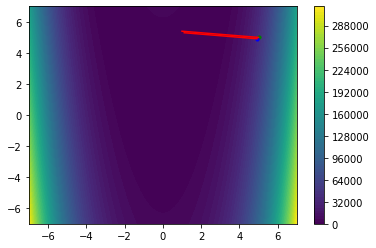

In [28]:

a = 7

x = torch.tensor([5., 5.])

# plot_contour(fn, -a, -a, a, a)
# traj, traj_grad = calc_sgd_trajectory(x, 10, lr=1e-6)
# plot_sgd_traj(traj, traj_grad, s=10, glen=1e-5)
# plt.show()

plot_contour(fn, -a, -a, a, a)
traj, traj_grad = calc_eps_intercept_trajectory(x, 2, eps=1e-1)
plot_eps_intercept_traj(traj, traj_grad, s=10, glen=1e-4)
plt.xlim(-a, a); plt.ylim(-a, a)
plt.show()

In [15]:
torch.manual_seed(1)
v1 = torch.randn(16, 2)
g1 = torch.randn(16, 2)
v2 = torch.randn(16, 2)
g2 = torch.randn(16, 2)

# v1 = torch.tensor([[0, 0.]])
# g1 = torch.tensor([[1, 0.]])
# v2 = torch.tensor([[0, -2.]])
# g2 = torch.tensor([[1, 2.]])/10.


In [16]:
it = intercept(v1, g1, v2, g2)

TypeError: scatter() got multiple values for argument 'marker'

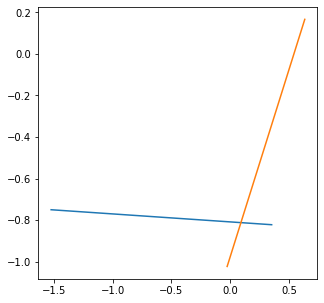

In [17]:

for i in range(len(v1)):
    plt.figure(figsize=(5, 5))
#     plt.quiver(*v1[i], *g1[i], scale=5)
#     plt.quiver(*v2[i], *g2[i], scale=5)
    
    plt.plot(*torch.stack([v1[i], v1[i]+g1[i]]).T)
    plt.plot(*torch.stack([v2[i], v2[i]+g2[i]]).T)
    plt.scatter(*it[i], marker='x', c='r', s=100)
    # plt.scatter(*it1[i], marker='x', c='g', s=100)

    plt.xlim(-4, 4); plt.ylim(-4, 4)
    plt.show()

In [5]:
def step_intercept_epsilon(x1, fn, eps=1e-2):
    x2 = x1 + eps*torch.randn_like(x1)
    f1, g1 = fg_fn(x1, fn)
    f2, g2 = fg_fn(x2, fn)
    x3 = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
    return x3

def step(x):
    fx = func(x)
    gx = grad(x)
    
    t = 1e-5
    while func(x-t*gx)<fx:
        t *= 2
    v1 = x-t/2.*gx
    v2 = x-t*gx
    v2 = v2+torch.randn_like(v2)*.1
    
    g1 = grad(v1)
    g2 = grad(v2)
    
    v3 = intercept(v1, -g1, v2, -g2)
    
    # plt.plot(*torch.stack([v1, (v1-g1/10.)]).T)
    # plt.plot(*torch.stack([v2, (v2-g2/10.)]).T)

    # plt.scatter(*v3, marker='x', c='r', s=100)
        

In [6]:
x1 = (torch.randn(100)*100).requires_grad_()
x2 = (torch.randn(2)*100).requires_grad_()

# f1, g1 = fg_quad(x1)
# f2, g2 = fg_quad(x2)

In [7]:
x1 = (torch.randn(100)).requires_grad_()
x3 = step_intercept_epsilon(x1, fn_quad, eps=1e-2)

In [406]:
# TODO the more parralel the two grad directions, the less you trust my intersection estimate
# use convex combination of (intersection estimate) and (mean of the two base points)

In [280]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.MaxPool2d(3),
        )
        self.classification = nn.Sequential(
            nn.Linear(32, 10),
            nn.LogSoftmax(dim=-1),
        )
    def forward(self, x):
        x = self.seq(x)
        x = x.reshape(len(x), -1)
        x = self.classification(x)
        return x

In [10]:
ds = mnist.MNIST()

In [11]:
net = mnist.Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)
print(np.sum([p.numel() for p in net.parameters()]))

net(torch.randn(1,1,28,28))

v = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

2162


In [17]:
data = {}

## MNIST Adam

In [16]:
net = mnist.Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)

meter_acc = metrics.AverageMeter(keep_verbose_stats=True)
meter_loss = metrics.AverageMeter(keep_verbose_stats=True)

for epoch_idx in range(5):
    for x, y in tqdm(ds.dl_train):
        yp = net(x)
        loss = ds.loss_fn(yp, y)
        acc = (yp.argmax(dim=-1)==y).sum().item()/len(x)

        opt.zero_grad()
        loss.backward()
        opt.step()

        meter_acc.update(acc, len(x))
        meter_loss.update(loss.item(), len(x))
        
data['adam_meter_loss'] = meter_loss
data['adam_meter_acc'] = meter_acc

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

NameError: name 'data' is not defined

## MNIST SGD w/ Momentum

In [51]:
net = mnist.Network()
opt = torch.optim.SGD(net.parameters(), lr=3e-3, momentum=0.9)

meter_acc = metrics.AverageMeter(keep_verbose_stats=True)
meter_loss = metrics.AverageMeter(keep_verbose_stats=True)

for epoch_idx in range(10):
    for x, y in tqdm(ds.dl_train):
        yp = net(x)
        loss = ds.loss_fn(yp, y)
        acc = (yp.argmax(dim=-1)==y).sum().item()/len(x)

        opt.zero_grad()
        loss.backward()
        opt.step()

        meter_acc.update(acc, len(x))
        meter_loss.update(loss.item(), len(x))
        
data['sgdm_meter_loss'] = meter_loss
data['sgdm_meter_acc'] = meter_acc

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [256]:
vo = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

In [257]:
fo, g = fg_fn_nn(vo, x, y)
fs = []

for t in tqdm(torch.logspace(-1, -3, 20)):
    f, _ = fg_fn_nn(vo+g*t, x, y)
    fs.append([t,f.item()])
fs.append([0, fo.item()])
for t in tqdm(-torch.logspace(-3, -1, 20)):
    f, _ = fg_fn_nn(vo+g*t, x, y)
    fs.append([t, f.item()])
fs = np.array(fs)

100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


(0.1917508840560913, 3.0)

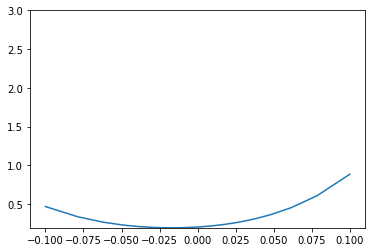

In [258]:
plt.plot(*fs.T)
plt.ylim(fs[:, 1].min(), 3)
# plt.xscale('symlog')

In [35]:
def step_epsilon(x1, x, y, net, opt, eps=1e-2):
    f1, g1 = fg_fn_nn(x1, x, y, net, opt)
    
    g1n = g1/g1.norm(dim=-1, keepdim=True)
    x2 = x1 + eps*torch.randn_like(x1)-g1n*eps

    f2, g2 = fg_fn_nn(x2, x, y, net, opt)
    x3, s, t = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
    return f1, x3, s, t

def step_smart(x1, x, y, t=1e-5):
    f1, g1 = fg_fn_nn(x1, x, y)
    
    ft, gt = fg_fn_nn(x1-t*g1, x, y)
    if ft<f1:
        while ft<f1:
            t *= 2.
            ft, gt = fg_fn_nn(x1-t*g1, x, y)
    elif ft>f1:
        while ft>f1:
            t /= 2.
            ft, gt = fg_fn_nn(x1-t*g1, x, y)
        t*=2.
        
    x2 = x1-t*g1
    x1 = x1-t/2.*g1
    
    f1, g1 = fg_fn_nn(x1, x, y)
    f2, g2 = fg_fn_nn(x2, x, y)
    x3 = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
    return f1, x3

In [36]:
def fg_fn_nn(v, x, y, net, opt):
    nn.utils.vector_to_parameters(v, net.parameters())
    opt.zero_grad()
    yp = net(x)
    loss = ds.loss_fn(yp, y)
    loss.backward()
    
    g = torch.cat([p.grad.flatten() for p in net.parameters()])
    return loss, g

## MNIST Two-Man-SGD

In [46]:
net = mnist.Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)
v = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

meter_acc = metrics.AverageMeter(keep_verbose_stats=True)
meter_loss = metrics.AverageMeter(keep_verbose_stats=True)

eps = 1e-3

for epoch_idx in range(5):
    for x, y in tqdm(ds.dl_train):
        f1, v2, s, t = step_epsilon(v, x, y, net, opt, eps)
        if s>0 and t>0:
            v = v2
        # f1, v = step_smart(v, x, y)
        # print('mean abs weight ', x1.abs().mean().item())
        
        yp = net(x)
        loss = ds.loss_fn(yp, y)
        acc = (yp.argmax(dim=-1)==y).sum().item()/len(x)
        print(loss.item())

        meter_acc.update(acc, len(x))
        meter_loss.update(loss.item(), len(x))
    
data['2mansgd_meter_loss'] = meter_loss
data['2mansgd_meter_acc'] = meter_acc

  0%|          | 0/60 [00:00<?, ?it/s]

2.306929588317871
2.306964874267578
2.3053083419799805
2.303544282913208
2.3101978302001953
2.3076982498168945
2.300717830657959
2.3017077445983887
2.2993483543395996
2.299300193786621
2.2970967292785645
2.2984228134155273
2.291470766067505
2.290900707244873
2.285202741622925
2.288174629211426
2.28349232673645
2.2765161991119385
2.2715277671813965
2.2592716217041016
2.246858596801758
2.2235829830169678
2.2027952671051025
2.190974712371826
2.1541213989257812
2.1522862911224365
2.0972657203674316
2.056318998336792
2.0238728523254395
2.0083017349243164
1.9914610385894775
2.415601968765259
1.9226861000061035
1.8681620359420776
2.499159097671509
2.055171489715576
1.719265103340149
1.9081871509552002
1.6170299053192139
1.5754786729812622
1.5073000192642212
1.4553254842758179
1.789981484413147
1.783484935760498
1.4079935550689697
1.2934229373931885
1.2660738229751587
1.2724018096923828
1.2034484148025513
1.1821447610855103
1.1649162769317627
1.262789011001587
1.2467542886734009
1.138871908187

  0%|          | 0/60 [00:00<?, ?it/s]

1.109770655632019
1.1225059032440186
1.3510196208953857
1.1452555656433105
1.0157305002212524
0.8929414749145508
0.9484080672264099
0.9316982626914978
0.9173012375831604
0.9756705164909363
0.8785281777381897
0.8670010566711426
0.9098538756370544
0.8883764147758484
0.805375337600708
0.8557956218719482
0.8381780385971069
0.8650021553039551
0.8204132914543152
0.8086961507797241
0.8180676102638245
0.8091164827346802
0.7898421883583069
0.7935196161270142
0.7653148770332336
0.7398489117622375
0.8067403435707092
0.8060460090637207
0.7870268225669861
0.7839380502700806
0.7485564947128296
0.7645903825759888
0.7032536864280701
0.7092224955558777
0.7628589272499084
0.7634931802749634
0.6867243051528931
0.7473077774047852
0.7593457698822021
0.7467542886734009
0.7512447237968445
0.7065802216529846
0.7075481414794922
0.7168947458267212
0.7172428369522095
0.6559234261512756
0.68013995885849
0.6936498284339905
0.7478117942810059
0.68342125415802
0.7004619240760803
0.7020083665847778
0.6725045442581177

  0%|          | 0/60 [00:00<?, ?it/s]

0.6949390769004822
0.64376300573349
0.692532479763031
0.7023005485534668
0.6500669717788696
0.6323114037513733
0.6514266729354858
0.5972737073898315
0.6302987933158875
0.6599792838096619
0.6344685554504395
0.5766602754592896
0.602486789226532
0.6293267011642456
0.6244304776191711
0.6173035502433777
0.6409844756126404
0.6123144030570984
0.6093479990959167
0.6921865940093994
0.593181848526001
0.5917486548423767
0.5755681395530701
0.6551984548568726
0.5880812406539917
0.5934187173843384
0.611301600933075
0.5442017316818237
0.5900558233261108
0.5954070091247559
0.6130818128585815
0.5444084405899048
0.5258212089538574
0.5499690771102905
0.6555588841438293
0.6438045501708984
0.6096259951591492
0.6452467441558838
0.6341838836669922
0.5994623303413391
0.6452757716178894
0.561469554901123
0.613176167011261
0.5124101042747498
0.5561509132385254
0.5297505855560303
0.5316535830497742
0.5218999981880188
0.6255045533180237
0.5438767671585083
0.5441992878913879
0.543181836605072
0.544776439666748
0.5

  0%|          | 0/60 [00:00<?, ?it/s]

0.5456307530403137
0.5884461998939514
0.5710768699645996
0.5728367567062378
0.5632874965667725
0.526580810546875
0.544688880443573
0.6021703481674194
0.49344050884246826
0.5324307680130005
0.7321754693984985
1.3229507207870483
0.9181615114212036
0.5564401149749756
0.5215097665786743
0.6075213551521301
0.49508997797966003
0.5421886444091797
0.5678573846817017
0.5177780389785767
0.4707910120487213
0.52837735414505
0.4778763949871063
0.5118964910507202
0.600389301776886
0.43857890367507935
0.4906174838542938
0.5065204501152039
0.5574837327003479
0.5380591154098511
0.48144668340682983
0.5216864347457886
0.4969635605812073
0.5158365964889526
0.7070197463035583
0.5563390851020813
0.5040324330329895
0.49019238352775574
0.4662533700466156
0.48457467555999756
0.4719911217689514
0.5071185827255249
0.49389830231666565
0.49162739515304565
0.470561146736145
0.5085861682891846
0.4435220956802368
0.47050461173057556
0.49304068088531494
0.4956128001213074
0.44916096329689026
0.41333839297294617
0.4602

  0%|          | 0/60 [00:00<?, ?it/s]

0.435485303401947
0.4319537878036499
0.44779664278030396
0.460136353969574
0.4685606360435486
0.42206111550331116
0.4798240661621094
0.4505029022693634
0.48899370431900024
0.46558284759521484
0.48484885692596436
0.5008060336112976
0.4348950982093811
0.5048145055770874
0.4464972913265228
0.4646649956703186
0.40381017327308655
0.4941958785057068
0.4130300283432007
0.4490847885608673
0.4040890634059906
0.433431476354599
0.49216586351394653
0.38844555616378784
0.4257233738899231
0.4430074691772461
0.4141944944858551
0.4180922210216522
0.42122551798820496
0.49217087030410767
0.3972243666648865
0.4219486713409424
0.38755783438682556
0.4204046428203583
0.4165908992290497
0.42466822266578674
0.446860671043396
0.6395357847213745
0.4384355843067169
0.4888404607772827
0.44645828008651733
0.6053901314735413
0.5161269307136536
0.5190061330795288
0.43171849846839905
0.4559069871902466
0.4395397901535034
0.41787707805633545
0.4072854816913605
0.42604753375053406
0.42369258403778076
0.4475698173046112

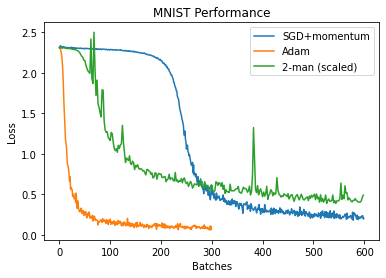

In [58]:
plt.plot(np.array(data['sgdm_meter_loss'].data)[:, 0], label='SGD+momentum')
plt.plot(np.array(data['adam_meter_loss'].data)[:, 0], label='Adam')
plt.plot(np.arange(300)*2, np.array(data['2mansgd_meter_loss'].data)[:, 0], label='2-man (scaled)')
plt.title('MNIST Performance'); plt.ylabel('Loss'); plt.xlabel('Batches')
plt.legend()

In [ ]:
# TODO: sample noise not randomly, but towards negative grad

# TODO: ignore intersection if line s or t values are negative
# (this means go away from the negative grad)